In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import numpy as np
import matplotlib.pyplot as plt


In [16]:
data_augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1)
])

In [ ]:
def create_cnn_model(
    input_shape=(32, 32, 3),
    num_classes=10,
    conv_layers=2,
    dense_layers=1,  
    initial_filters=32,
    l2_lambda=0.001,
    filter_growth_rate=2,
    learning_rate=0.001
):
    model = models.Sequential([
        # data_augmentation_layer,
        layers.Rescaling(1./255)
    ])
    
    model.add(layers.Conv2D(initial_filters, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(l2_lambda)))
    
    current_filters = initial_filters
    for _ in range(conv_layers):
        current_filters *= filter_growth_rate
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(current_filters, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    
    model.add(layers.Flatten())
    
    for _ in range(dense_layers):
        model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    return model

In [80]:
def train_model(
    model,
    x_train, 
    y_train, 
    epochs=40,
    batch_size=32,
    early_stopping=True,
    learning_rate_decay=True
):

    callbacks = []
    if early_stopping:
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10, 
            restore_best_weights=True
        )
        callbacks.append(early_stop)
    
    if learning_rate_decay:
        lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=5
        )
        callbacks.append(lr_schedule)
    
    history = model.fit(
        x_train, y_train, 
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks
    )
    
    return history

In [82]:
x_train = np.load("/home/splintersword/Documents/Computers/Image_Classification/data/processed/x_train.npy")
y_train = np.load("/home/splintersword/Documents/Computers/Image_Classification/data/processed/y_train.npy")
model = create_cnn_model()
history = train_model(model,x_train,y_train,100)

Epoch 1/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.3470 - loss: 1.8656 - learning_rate: 0.0010
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.5538 - loss: 1.3757 - learning_rate: 0.0010
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.6223 - loss: 1.2338 - learning_rate: 0.0010
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.6574 - loss: 1.1495 - learning_rate: 0.0010
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.6797 - loss: 1.1047 - learning_rate: 0.0010
Epoch 6/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.6962 - loss: 1.0693 - learning_rate: 0.0010
Epoch 7/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7113 - loss: 1.0281 - learning_rate: 0.0010
Epoch 8/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7238 - loss: 1.0031 - learning_rate: 0.0010
Epoch 9/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7320 - loss: 0.98

In [83]:
def plot_training_history(history):
    """
    Visualize model training performance
    
    Args:
        history: Keras training history object
    """
    plt.figure(figsize=(12, 4))
    
    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    # plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    # plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def evaluate_model_performance(model, x_test, y_test):
    """
    Comprehensive model evaluation
    
    Args:
        model: Trained Keras model
        x_test: Test input data
        y_test: Test target data
    
    Returns:
        Performance metrics dictionary
    """
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    
    return {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy
    }

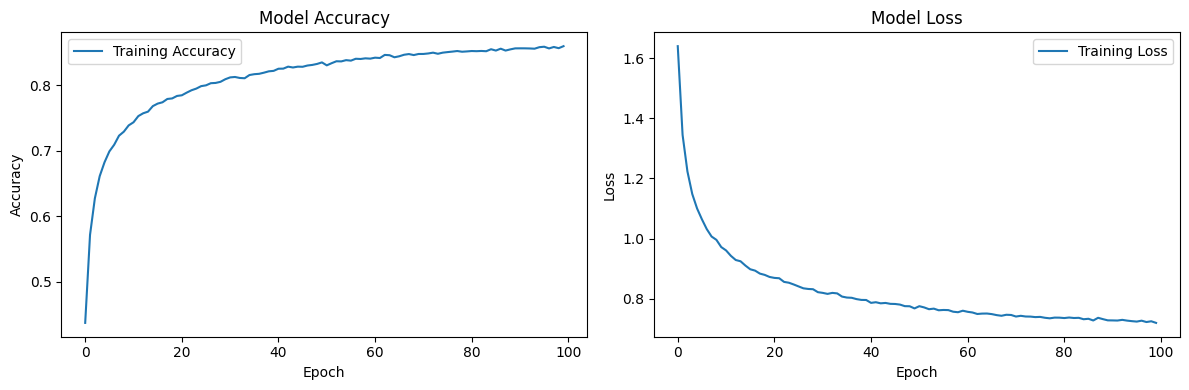

In [84]:
plot_training_history(history)

In [85]:
x_test = np.load("/home/splintersword/Documents/Computers/Image_Classification/data/raw/x_test.npy")
y_test = np.load("/home/splintersword/Documents/Computers/Image_Classification/data/raw/y_test.npy")

model.evaluate(x_test,y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7338 - loss: 1.2057


[1.2092030048370361, 0.729200005531311]

In [89]:
model.predict(x_test)[3]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([9.9041331e-01, 2.6096886e-03, 8.6486933e-04, 5.7999496e-05,
       3.4632551e-04, 2.0671362e-07, 1.3735983e-07, 2.6008010e-07,
       4.9008843e-03, 8.0635870e-04], dtype=float32)

In [90]:
print(y_test[3])

[0]


In [ ]:
def hyper_modal(hp):

    model = models.Sequential([
        layers.Rescaling(1./255)
    ])
    
    initial_filters = hp.Int('Layer 1', min_value = 1, max_value = 64, step = 4)
    layer_2_filters = hp.Int('Layer 2', min_value = 32, max_value = 128, step = 4)
    layer_3_filters = hp.Int('Layer 3', min_value = 64, max_value = 264, step = 4)
    dense_layer_units = hp.Int('Dense_Layer', min_value = 1, max_value = 128, step = 4)
    learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
    l2_lambda = hp.Choice('l2_lambda', values=[0.01, 0.001, 0.0001])

    model.add(layers.Conv2D(initial_filters, (3, 3), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Conv2D(layer_2_filters, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Conv2D(layer_3_filters, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))

    model.add(layers.Flatten())

    model.add(layers.Dense(dense_layer_units, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Dense(10, activation='softmax'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    return model

In [98]:
import keras_tuner as kt

tuner = kt.Hyperband(hyper_modal, objective='val_accuracy', max_epochs=40, factor=3, directory='dir', project_name='x')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

/home/splintersword/.local/share/virtualenvs/Image_Classification-nc8MtVhL/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
tuner.search(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Trial 2 Complete [00h 04m 00s]
val_accuracy: 0.09969999641180038

Best val_accuracy So Far: 0.4618000090122223
Total elapsed time: 00h 06m 00s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
13                |21                |Layer 1
64                |52                |Layer 2
88                |84                |Layer 3
41                |21                |Dense_Layer
0.0001            |0.0001            |learning_rate
0.001             |0.0001            |l2_lambda
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
 206/1250 ━━━━━━━━━━━━━━━━━━━━ 1:04 62ms/step - accuracy: 0.1801 - loss: 2.3499